# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

The car dealer could be interest in predicting the price of a car based on its attributes. More precise, we try to answer to the following 3 business questions:

- Is the price of a car related to the number of Cylinders?
- Is the price of a car related to the Make, Model, year?
- Is the price of a car related to the current milage/odometer?
- Is the price of a car related to the MPG?
Can the price of a car be predicted based in its attribute with reasonable accuracy?

###### First things first, importing all the required libraries

In [115]:

import pandas as pd
import numpy as np
from numpy import percentile

import plotly.express as px
from matplotlib.ticker import ScalarFormatter
import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial

from scipy.stats import norm
from scipy import stats

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.compose import make_column_transformer, make_column_selector, TransformedTargetRegressor, ColumnTransformer
from scipy.stats import boxcox
from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error,median_absolute_error, r2_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.inspection import permutation_importance
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn import set_config

set_config(display="diagram")
import warnings
warnings.filterwarnings("ignore")

import warnings
warnings.filterwarnings('ignore')

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

Load the data and familiarize with it

- See the available columns and their data-types
- Some standard details like the min, max, std-dev of the numerical variables and possible values in the categorical variables
- What percentage of data has null values. Start thinking about how to deal with them. Is there a logical way of filling the null values?
- Are there unreasonable values in the numerical variables.
- Check the histograms and distributions to understand if scaling is needed

In [2]:
vehicles = pd.read_csv('data/vehicles.csv')

In [3]:
#variable to hold initial dataset row size
vehicles_initial_dataset = vehicles.shape[0]

In [4]:
vehicles.sample(5)

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
62163,7316445158,SF bay area,18981,2018.0,nissan,kicks,NaN,4 cylinders,gas,34056.0,clean,automatic,3N1CP5CUXJL516149,fwd,NaN,sedan,grey,ca
275382,7316488357,new york city,20000,2011.0,ford,f-150,excellent,NaN,gas,68100.0,clean,automatic,1FTVX1EF0BKD53754,NaN,NaN,pickup,yellow,ny
146191,7314324226,springfield,7495,2012.0,gmc,acadia,excellent,6 cylinders,gas,151000.0,clean,automatic,NaN,fwd,full-size,SUV,red,il
272998,7314095785,long island,0,2012.0,jeep,grand+cherokee,excellent,NaN,gas,59826.0,clean,automatic,1C4RJFAGXCC299311,NaN,NaN,SUV,black,ny
344546,7308767764,charleston,29590,2013.0,gmc,sierra 1500 extended cab slt,good,8 cylinders,gas,37888.0,clean,other,1GTR1WE01DZ407455,NaN,NaN,pickup,silver,sc


In [5]:
vehicles.duplicated().sum()

0

No duplicates from initial dataset

Assumption: selling price is in USD.

###### The following columns are categorical 

In [6]:
vehicles_categorical_features = vehicles.select_dtypes(exclude=np.number).columns.tolist()
vehicles_categorical_features 

['region',
 'manufacturer',
 'model',
 'condition',
 'cylinders',
 'fuel',
 'title_status',
 'transmission',
 'VIN',
 'drive',
 'size',
 'type',
 'paint_color',
 'state']

In [7]:
print("There are {} categorical columns.".format(len(vehicles_categorical_features)))

There are 14 categorical columns.


In [8]:
#size of intital dataset
vehicles.shape

(426880, 18)

And 'price' is our target

In [9]:
vehicles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [10]:
vehicles.columns

Index(['id', 'region', 'price', 'year', 'manufacturer', 'model', 'condition',
       'cylinders', 'fuel', 'odometer', 'title_status', 'transmission', 'VIN',
       'drive', 'size', 'type', 'paint_color', 'state'],
      dtype='object')

### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

ID, region, state, VIN have little impact on the decisons of used car selling so, I am going to drop these columns from the dataset.

###### Drop features that are not required/imiportant to the the price of a vehicle 

In [11]:
vehicles = vehicles.drop(['id', 'region','VIN','state'],axis='columns')

Check null values

In [12]:
vehicles.isnull().sum()

price                0
year              1205
manufacturer     17646
model             5277
condition       174104
cylinders       177678
fuel              3013
odometer          4400
title_status      8242
transmission      2556
drive           130567
size            306361
type             92858
paint_color     130203
dtype: int64

The data contains missing values and hence data cleaning is necessary. 

There are a number of NAN/Nulls, we can use different imputer techniques to populate the missing values.

In [13]:
vehicles.duplicated().sum()

178577

When we remove ['id', 'region','VIN','state'] columns we got the above duplicates

For clarity "odometer" is commonly known as mileage, so rename the column accordingly

In [14]:
vehicles.rename(columns = {'odometer':'Mileage'}, inplace = True)

In [15]:
## remove duplicates.
vehicles.drop_duplicates(inplace=True)

In [16]:
vehicles.shape

(248303, 14)

In [17]:
#copy dataset for processing
vehicles_step1 = vehicles.copy(deep=True)

In [18]:
vehicles_step1.isnull().sum()

price                0
year               695
manufacturer     10861
model             3695
condition        98985
cylinders        89404
fuel              1707
Mileage           2526
title_status      4207
transmission      1358
drive            70642
size            160641
type             62629
paint_color      74738
dtype: int64

Impute missing values for a numerical feature using the average of the nearest three values.

In [20]:
knnimputer = KNNImputer(n_neighbors=3)
num = [col for col in vehicles_step1.columns if vehicles_step1[col].dtypes != 'O']
vehicles_step1= knnimputer.fit_transform(vehicles_step1[num])


In [21]:
vehicles_step1= pd.DataFrame(vehicles_step1)
vehicles_step1.rename(columns = {0:'Price',1:'Year',2:'Mileage' }, inplace = True)
vehicles_step1['Year'] = pd.to_datetime(vehicles_step1['Year'], format='%Y').dt.year


In [22]:
vehicles_step1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248303 entries, 0 to 248302
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   Price    248303 non-null  float64
 1   Year     248303 non-null  int64  
 2   Mileage  248303 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 5.7 MB


In [23]:
vehicles_step1.duplicated().sum()

15496

In [26]:
vehicles_step2 = vehicles.copy(deep=True)
vehicles_step2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 248303 entries, 0 to 426873
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         248303 non-null  int64  
 1   year          247608 non-null  float64
 2   manufacturer  237442 non-null  object 
 3   model         244608 non-null  object 
 4   condition     149318 non-null  object 
 5   cylinders     158899 non-null  object 
 6   fuel          246596 non-null  object 
 7   Mileage       245777 non-null  float64
 8   title_status  244096 non-null  object 
 9   transmission  246945 non-null  object 
 10  drive         177661 non-null  object 
 11  size          87662 non-null   object 
 12  type          185674 non-null  object 
 13  paint_color   173565 non-null  object 
dtypes: float64(2), int64(1), object(11)
memory usage: 28.4+ MB


In [27]:
vehicles_step2.duplicated().sum()

0

In [28]:
obj = [col for col in vehicles_step2.columns if vehicles_step2[col].dtypes == 'O']
obj

['manufacturer',
 'model',
 'condition',
 'cylinders',
 'fuel',
 'title_status',
 'transmission',
 'drive',
 'size',
 'type',
 'paint_color']

Impute missing values for a categorical feature using the most frequest category than dropping the entire data.

In [29]:
imputer = SimpleImputer(strategy='most_frequent')

vehicles_step2= imputer.fit_transform(vehicles_step2[obj])
vehicles_step2= pd.DataFrame(vehicles_step2)


In [30]:
vehicles_step2.rename(columns = {0:'Manufacturer',1:'Model',2:'Condition',3:'Cylinders',4:'Fuel',5:'Title_Status', \
                                6:'Transmission',7:'Drive',8:'Size',9:'Type',10:'Paint_Color'}, inplace = True)

In [31]:
vehicles_df = pd.concat([vehicles_step2,vehicles_step1], axis=1,ignore_index=True)

vehicles_df.shape

(248303, 14)

In [32]:
vehicles_df.rename(columns = {0:'Manufacturer',1:'Model',2:'Condition',3:'Cylinders',4:'Fuel',5:'Title_Status', \
                                6:'Transmission',7:'Drive',8:'Size',9:'Type',10:'Paint_Color',11:'Price',12:'Year', \
                                 13:'Mileage'}, inplace = True)

In [33]:
vehicles_df.head(5)

,Manufacturer,Model,Condition,Cylinders,Fuel,Title_Status,Transmission,Drive,Size,Type,Paint_Color,Price,Year,Mileage
0,ford,f-150,excellent,4 cylinders,gas,clean,automatic,4wd,full-size,sedan,white,6000.0,2007,128443.666667
1,ford,f-150,excellent,4 cylinders,gas,clean,automatic,4wd,full-size,sedan,white,11900.0,2009,160644.000000
2,ford,f-150,excellent,4 cylinders,gas,clean,automatic,4wd,full-size,sedan,white,21000.0,2014,118631.666667
3,ford,f-150,excellent,4 cylinders,gas,clean,automatic,4wd,full-size,sedan,white,1500.0,2001,144700.000000
4,ford,f-150,excellent,4 cylinders,gas,clean,automatic,4wd,full-size,sedan,white,4900.0,2006,212243.333333


In [34]:
vehicles_df.shape

(248303, 14)

In [35]:
vehicles_df.duplicated().sum()

605

Further checking the categorical columns.

In [36]:
len(vehicles_df['Model'].unique())
print("There are {} car Model categories".format(len(vehicles_df['Model'].unique())))

There are 29649 car Model categories


There are 29649 different car models in this dataset, better to drop this column.

In [37]:
#drop model column
vehicles_df = vehicles_df.drop(['Model'],axis='columns')

Unique values of each of the other categorical featues.

In [38]:
print(vehicles_df['Condition'].unique())
print(vehicles_df['Cylinders'].unique())
print(vehicles_df['Fuel'].unique())
print(vehicles_df['Title_Status'].unique())
print(vehicles_df['Transmission'].unique())
print(vehicles_df['Drive'].unique())
print(vehicles_df['Size'].unique())
print(vehicles_df['Type'].unique())
print(vehicles_df['Paint_Color'].unique())
print(vehicles_df['Manufacturer'].unique())


['excellent' 'good' 'fair' 'like new' 'new' 'salvage']
['4 cylinders' '8 cylinders' '6 cylinders' '5 cylinders' 'other'
 '3 cylinders' '10 cylinders' '12 cylinders']
['gas' 'other' 'diesel' 'hybrid' 'electric']
['clean' 'rebuilt' 'lien' 'salvage' 'missing' 'parts only']
['automatic' 'other' 'manual']
['4wd' 'rwd' 'fwd']
['full-size' 'mid-size' 'compact' 'sub-compact']
['sedan' 'pickup' 'truck' 'other' 'coupe' 'SUV' 'hatchback' 'mini-van'
 'offroad' 'bus' 'van' 'convertible' 'wagon']
['white' 'blue' 'red' 'black' 'silver' 'grey' 'brown' 'yellow' 'orange'
 'green' 'custom' 'purple']
['ford' 'gmc' 'chevrolet' 'toyota' 'jeep' 'nissan' 'ram' 'mazda'
 'cadillac' 'honda' 'dodge' 'lexus' 'jaguar' 'buick' 'chrysler' 'volvo'
 'audi' 'infiniti' 'lincoln' 'alfa-romeo' 'subaru' 'acura' 'hyundai'
 'mercedes-benz' 'bmw' 'mitsubishi' 'volkswagen' 'porsche' 'kia' 'rover'
 'ferrari' 'mini' 'pontiac' 'fiat' 'tesla' 'saturn' 'mercury'
 'harley-davidson' 'datsun' 'aston-martin' 'land rover' 'morgan']


In [39]:
#check for NAN values
vehicles_df.isnull().sum()

Manufacturer    0
Condition       0
Cylinders       0
Fuel            0
Title_Status    0
Transmission    0
Drive           0
Size            0
Type            0
Paint_Color     0
Price           0
Year            0
Mileage         0
dtype: int64

As expected all the null values are fixed now

In [40]:
#size of current dataset
vehicles_df.shape

(248303, 13)

In [41]:
vehicles_df.sample(5)

,Manufacturer,Condition,Cylinders,Fuel,Title_Status,Transmission,Drive,Size,Type,Paint_Color,Price,Year,Mileage
55088,volvo,excellent,5 cylinders,gas,clean,automatic,fwd,mid-size,sedan,silver,6950.0,2010,115695.0
215894,chevrolet,excellent,8 cylinders,gas,clean,manual,rwd,compact,coupe,red,17495.0,2010,86901.0
11079,ram,excellent,8 cylinders,gas,clean,automatic,4wd,full-size,truck,white,12999.0,2008,242027.0
189404,nissan,excellent,4 cylinders,gas,clean,automatic,fwd,full-size,SUV,white,0.0,2018,22369.0
206758,ford,excellent,4 cylinders,gas,salvage,automatic,fwd,full-size,sedan,white,6900.0,2016,73000.0


Use a plot to pick datapoints to window down data of interest based on the distributions

<AxesSubplot:xlabel='Year', ylabel='Density'>

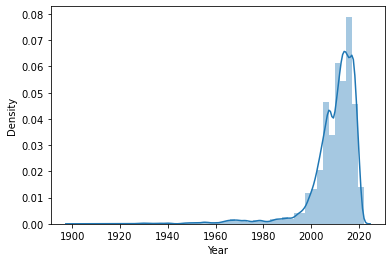

In [43]:
# Data distribution over the year
sns.distplot((vehicles_df["Year"]))

Up on further exploration of the dataset, we found out that there is a big range of "year" starting from 1900 and price starting from $0 (free) and some cars "Title Status" for just "parts only". so, decided to use data windowing. these can be legitmate data or not but these are extreme outliers and can skew the statistical power of our data analysis.

<AxesSubplot:xlabel='Price', ylabel='Density'>

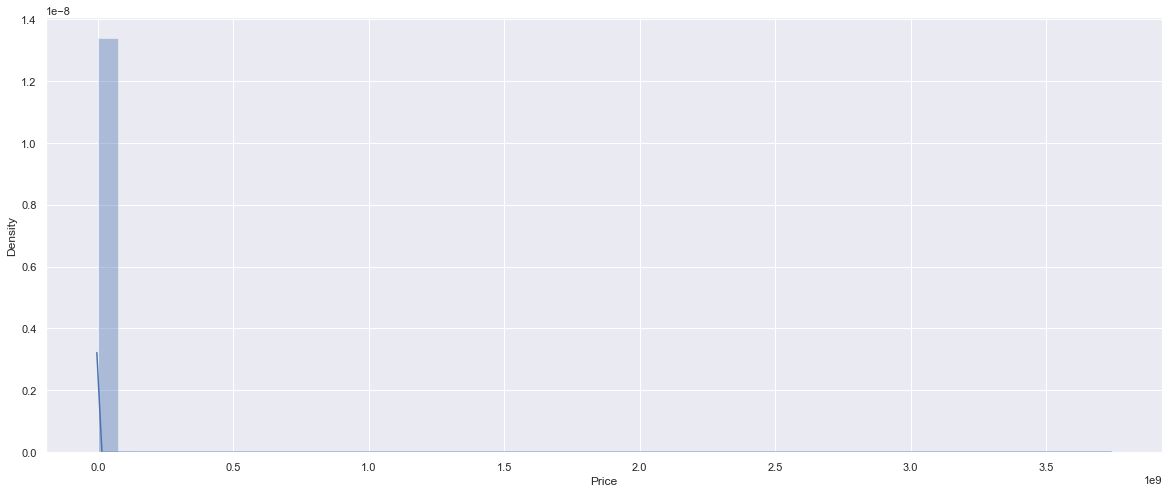

In [44]:
# Data distribution over the Price
sns.set(rc={'figure.figsize':(20,8)})
sns.distplot((vehicles_df["Price"]))

<AxesSubplot:xlabel='Mileage', ylabel='Density'>

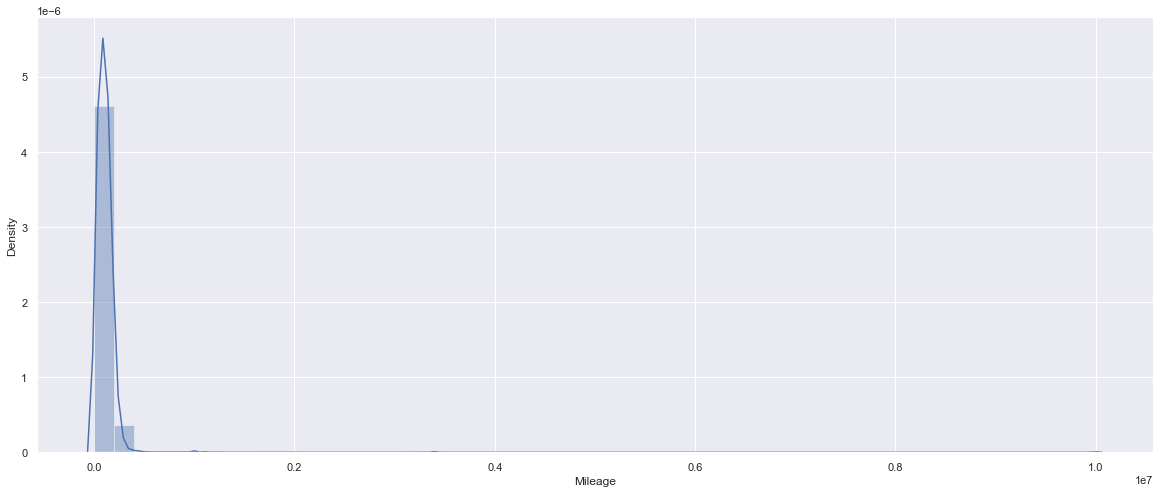

In [45]:
# Record distribution over the milage of the cars
sns.distplot((vehicles_df["Mileage"]))

Based on observation of the above plots take datapoinst to window the dataset base on distribution.
- for 'Year' majority of the data concentrated between year 2000 and now.
- For the 'Price' and 'Milage' difficutl to read from the graphs
- Only filter vechicle sold for driving purposes not for parts only

so for the first attempt is just window down the price for 'Year' and explor the Pirce and Milage data points

In [58]:
# window the dataset
#maximum realistic Milage capped at 175000
#maximum price afor a used car capped at $50000

vehicles_df = vehicles_df.query(' \
    (200 < Price < 50000) & \
    ( 2005 < Year < 2022 ) & \
    ( 1000 < Mileage < 175000 ) & \
    Title_Status != "parts only" \
')


In [48]:
vehicles_df = vehicles_df.copy()
vehicles_df.shape

(151596, 13)

<AxesSubplot:xlabel='Price', ylabel='Density'>

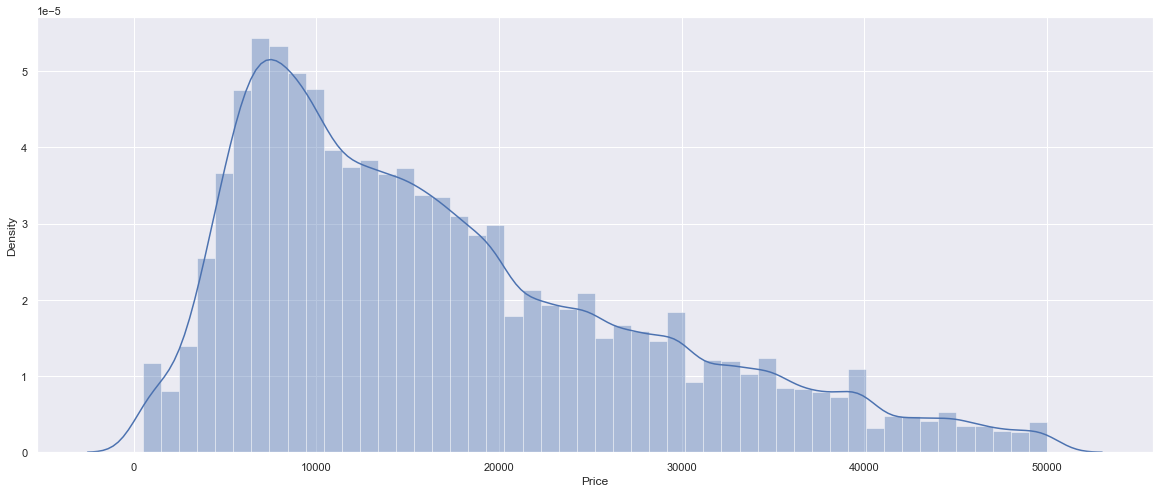

In [59]:
# Re-plot Data distribution over the Price
sns.set(rc={'figure.figsize':(20,8)})
sns.distplot((vehicles_df["Price"]))

<AxesSubplot:xlabel='Mileage', ylabel='Density'>

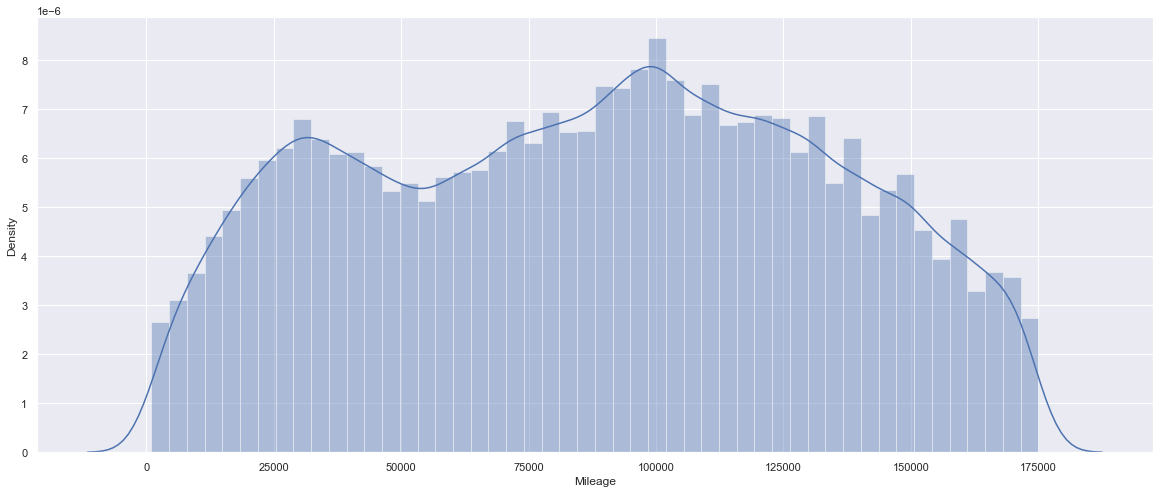

In [50]:
# Record distribution over the milage of the cars
sns.distplot((vehicles_df["Mileage"]))

From the above plots we can see the distribution of  Milage and Price and we can further window down our dataset
- 'Price' Starting from 500 to 50000
- 'Mileage' starting from 1000 to 175000 miles

In [60]:
vehicles_df = vehicles_df.query(' \
    (500 < Price < 50000) & \
    ( 2005 < Year < 2022 ) & \
    ( 1000 < Mileage < 175000 )')


One more check for the Mileage and Price distributions

<AxesSubplot:xlabel='Price', ylabel='Density'>

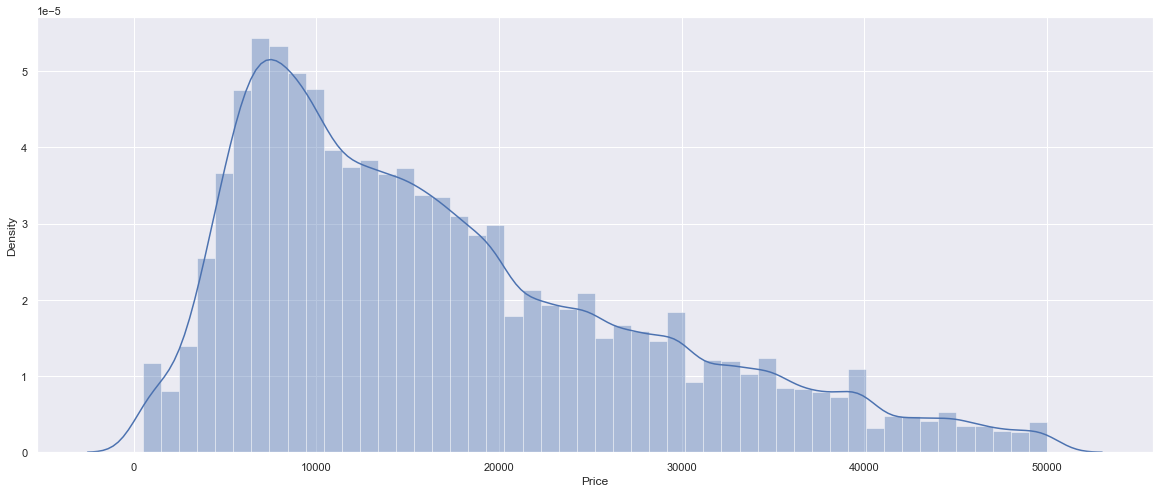

In [61]:
# Final plot Data distribution over the Price
sns.set(rc={'figure.figsize':(20,8)})
sns.distplot((vehicles_df["Price"]))

<AxesSubplot:xlabel='Mileage', ylabel='Density'>

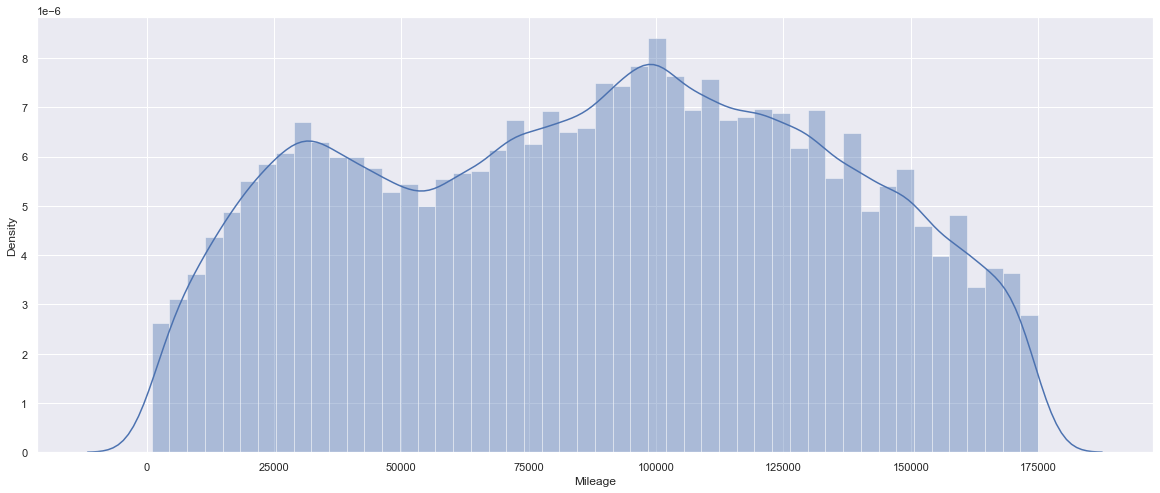

In [53]:
# Record distribution over the milage of the cars
sns.distplot((vehicles_df["Mileage"]))

In [62]:
# fix the categorical ranking for condition

print(vehicles_df['Condition'].unique())
vehicles_df['Condition'] = vehicles_df['Condition'].astype('category')
vehicles_df['Condition'] = vehicles_df['Condition'].cat.set_categories(
    ['salvage', 'fair', 'good', 'excellent', 'like new', 'new'], ordered=True)

['excellent', 'good', 'fair', 'like new', 'new', 'salvage']
Categories (6, object): ['salvage' < 'fair' < 'good' < 'excellent' < 'like new' < 'new']


In [63]:
#size of current dataset after windowing
vehicles_df.shape

(148888, 13)

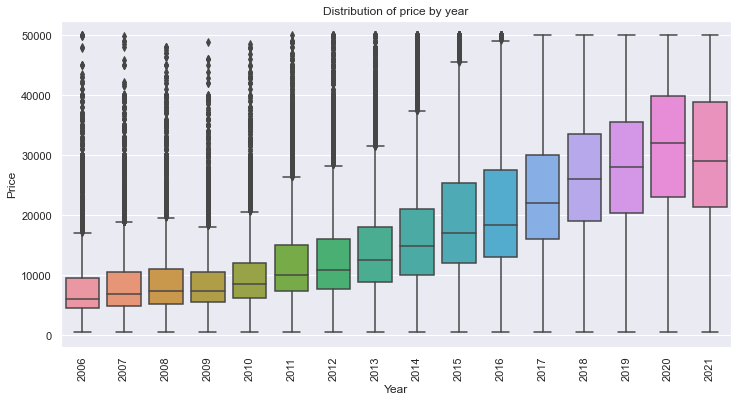

In [64]:
## make box plot to show behavior of car price by year 

sns.set(rc={'figure.figsize':(12,6)})
sns.boxplot(data=vehicles_df, x='Year', y='Price').set(title='Distribution of price by year')
ax = plt.xticks(rotation=90)
plt.show()

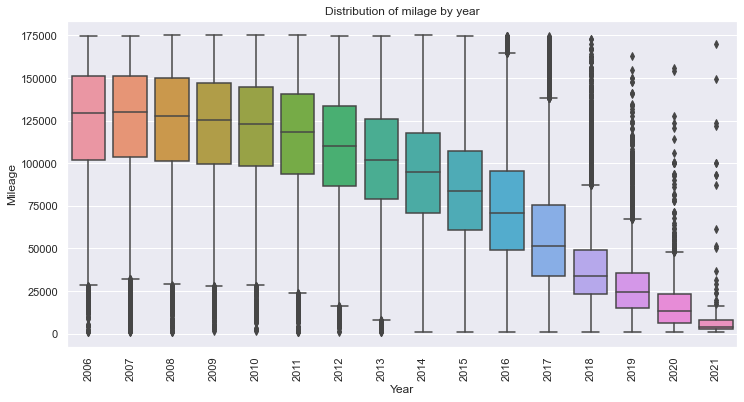

In [65]:
## mileage by year
##
sns.set(rc={'figure.figsize':(12,6)})
sns.boxplot(data=vehicles_df, x='Year', y='Mileage').set(title='Distribution of milage by year')
ax = plt.xticks(rotation=90)
plt.show()


From the bove box plots we can see the existance of outliers and there is an obvious invalid data for the year 2022, this migh be casued by data imputing

#### Outlier detection and removal.

#####  1 - Outlier Detection

###### Checking Distribution of year, price and mileage (odometer)

<AxesSubplot:xlabel='Mileage', ylabel='Density'>

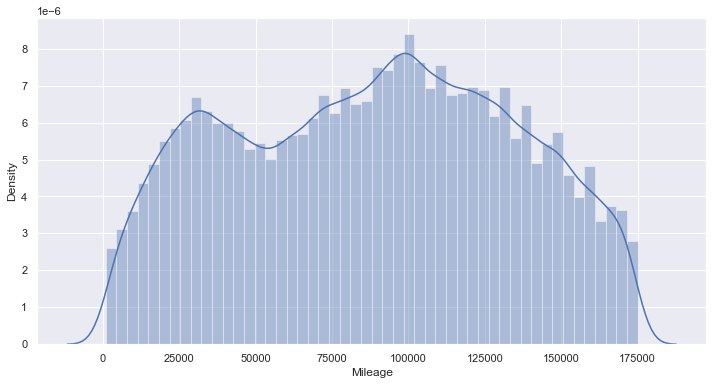

In [66]:
# Record distribution over the milage of the cars
sns.distplot((vehicles_df["Mileage"]))

We can see from the visualizations there are certain number of outliers.

In [67]:
vehicles_df.agg(['skew', 'kurtosis']).transpose()

,skew,kurtosis
Price,0.880202,0.083692
Year,-0.236825,-0.905719
Mileage,-0.038784,-1.037383


In [68]:
vehicles_df.describe()

,Price,Year,Mileage
count,148888.000000,148888.000000,148888.000000
mean,17069.260323,2013.422150,88076.823308
std,10925.273857,3.824085,45418.031450
min,501.000000,2006.000000,1001.000000
25%,8495.000000,2011.000000,49585.500000
50%,14500.000000,2014.000000,90340.000000
75%,23735.000000,2017.000000,124325.000000
max,49999.000000,2021.000000,174997.000000


From the describe above we can see that 75% of the price is below 23k and min price is $501.

###### Explore the high and lows

In [69]:
vehicles_df.sort_values(by=['Price'], ascending=False).head(5)[['Price','Year','Mileage']] 

,Price,Year,Mileage
136339,49999.0,2019,31000.0
33931,49999.0,2018,131104.0
84220,49999.0,2018,53095.0
233839,49999.0,2019,44353.0
188203,49999.0,2020,18072.0


In [70]:
vehicles_df.sort_values(by=['Price'], ascending=False).tail(5)[['Price','Year','Mileage']] 

,Price,Year,Mileage
26469,501.0,2016,70153.0
140378,501.0,2014,57874.0
234212,501.0,2017,47982.0
91646,501.0,2018,35087.0
192757,501.0,2020,14672.0


In [71]:
vehicles_df.sort_values(by=['Mileage'], ascending=False).head(5)[['Price','Year','Mileage']] 

,Price,Year,Mileage
57602,4500.0,2008,174997.0
220980,13991.0,2014,174996.0
123788,4995.0,2009,174988.0
123625,4495.0,2009,174988.0
61646,4999.0,2011,174986.0


In [72]:
vehicles_df.sort_values(by=['Mileage'], ascending=False).tail(5)[['Price','Year','Mileage']] 

,Price,Year,Mileage
29075,1650.0,2020,1009.0
5828,21990.0,2020,1007.0
88438,8490.0,2015,1003.0
125966,19500.0,2020,1001.0
126208,21999.0,2020,1001.0


In [73]:
vehicles_df.sort_values(by=['Year'], ascending=False).head(5)[['Price','Year','Mileage']] 

,Price,Year,Mileage
192823,23495.0,2021,4089.0
131994,31990.0,2021,1365.0
88962,41977.0,2021,6433.0
5556,28709.0,2021,26000.0
5557,22839.0,2021,5363.0


In [74]:
vehicles_df.sort_values(by=['Year'], ascending=False).tail(5)[['Price','Year','Mileage']]  

,Price,Year,Mileage
199281,6700.0,2006,141110.0
239798,4499.0,2006,84000.0
152005,7500.0,2006,86032.0
239790,5300.0,2006,170000.0
44354,6495.0,2006,129656.0


###### 2- Outlier Removal

We will use percentile to detect the extreme values (outliers) of the price for each year 

Remove the price outliers for each year with the 5%-95% percentile for each year.

In [75]:
df_filtered = pd.DataFrame(columns=vehicles_df.columns)
years_list = vehicles_df['Year'].sort_values().unique()

for y in years_list:
    n = vehicles_df.query('Year == @y')['Price'].count()
    q_low = vehicles_df.query('Year == @y')['Price'].quantile(0.05)
    q_hi  = vehicles_df.query('Year == @y')['Price'].quantile(0.95)
    df_tmp = vehicles_df.query('Year == @y & ( @q_low < Price <= @q_hi )') 
    nf = df_tmp.Price.count()
    df_filtered = pd.concat( [df_tmp, df_filtered], axis=0, ignore_index=True )

In [76]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133795 entries, 0 to 133794
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   Manufacturer  133795 non-null  object
 1   Condition     133795 non-null  object
 2   Cylinders     133795 non-null  object
 3   Fuel          133795 non-null  object
 4   Title_Status  133795 non-null  object
 5   Transmission  133795 non-null  object
 6   Drive         133795 non-null  object
 7   Size          133795 non-null  object
 8   Type          133795 non-null  object
 9   Paint_Color   133795 non-null  object
 10  Price         133795 non-null  object
 11  Year          133795 non-null  object
 12  Mileage       133795 non-null  object
dtypes: object(13)
memory usage: 13.3+ MB


In [77]:
## fix the data types for some of the columns below
df_filtered['Price'] = df_filtered['Price'].astype(float)
df_filtered['Year'] = df_filtered['Year'].astype(int)
df_filtered['Condition'] = df_filtered['Condition'].astype('category')
df_filtered['Mileage'] = df_filtered['Mileage'].astype(float)

In [78]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133795 entries, 0 to 133794
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   Manufacturer  133795 non-null  object  
 1   Condition     133795 non-null  category
 2   Cylinders     133795 non-null  object  
 3   Fuel          133795 non-null  object  
 4   Title_Status  133795 non-null  object  
 5   Transmission  133795 non-null  object  
 6   Drive         133795 non-null  object  
 7   Size          133795 non-null  object  
 8   Type          133795 non-null  object  
 9   Paint_Color   133795 non-null  object  
 10  Price         133795 non-null  float64 
 11  Year          133795 non-null  int32   
 12  Mileage       133795 non-null  float64 
dtypes: category(1), float64(2), int32(1), object(9)
memory usage: 11.9+ MB


In [79]:
df_filtered.shape

(133795, 13)

In [80]:
vehicles_df = df_filtered.copy(deep=True)

In [ ]:
vehicles_df.shape

Check random sample and see (using intution) any out of ordinary or unusuall datapoints.

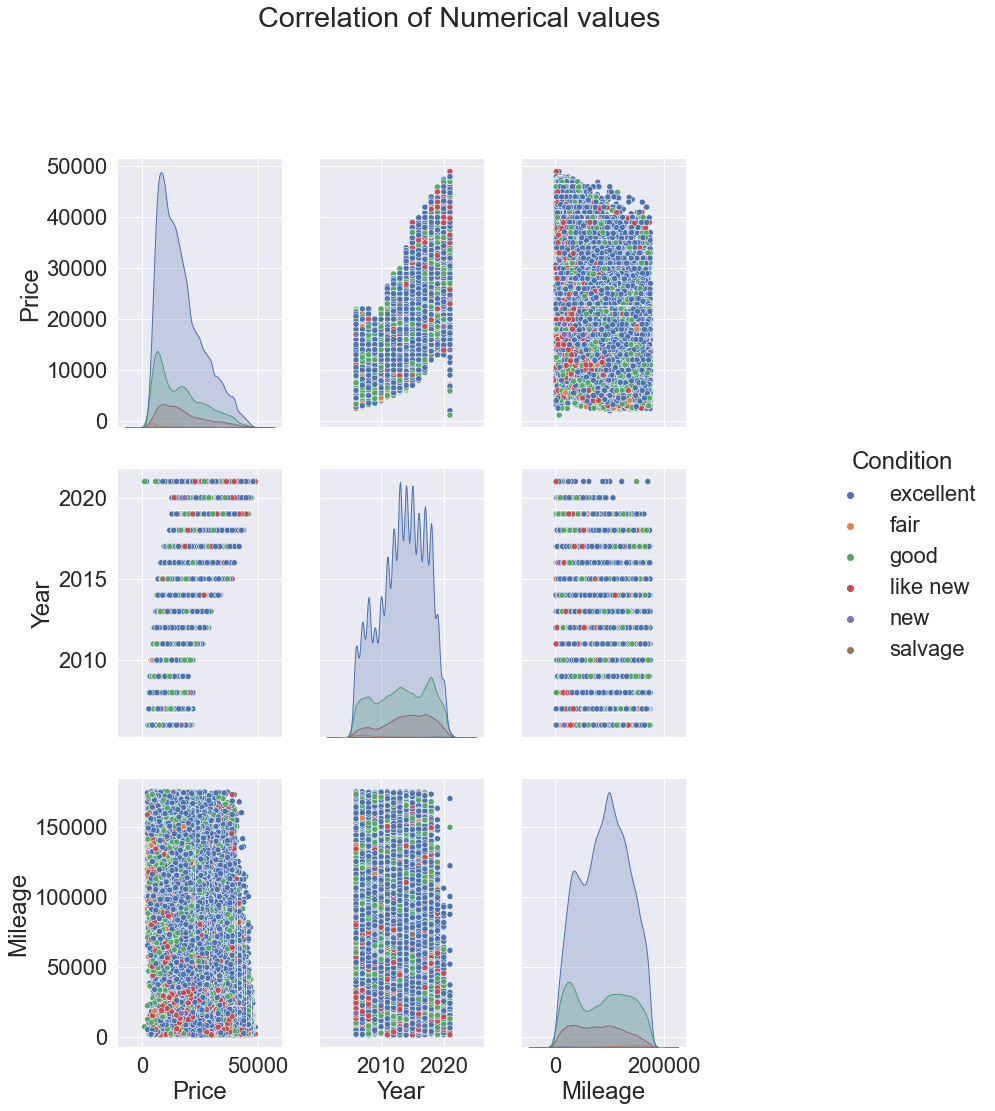

In [81]:
### examine the numerical values for correlation between variables

sns.set(font_scale=2)
g = sns.pairplot(vehicles_df, hue='Condition')
g.fig.suptitle('Correlation of Numerical values',y =1.10)
g.fig.set_size_inches(15,15)
plt.show()

The above pair plots show the following correlations.
- Price of Vehicle decreases as it gets older and vice versa.
- Price of vehicle decreases as its milage/odometer readings increase.

One more plots after dataclean up.

<AxesSubplot:xlabel='Price', ylabel='Density'>

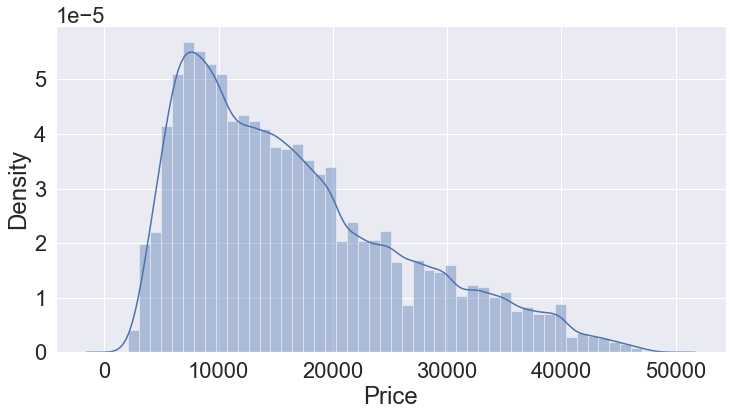

In [82]:
# Distribution of the dataset over the Price
sns.distplot((vehicles_df["Price"]))

<AxesSubplot:xlabel='Year', ylabel='Density'>

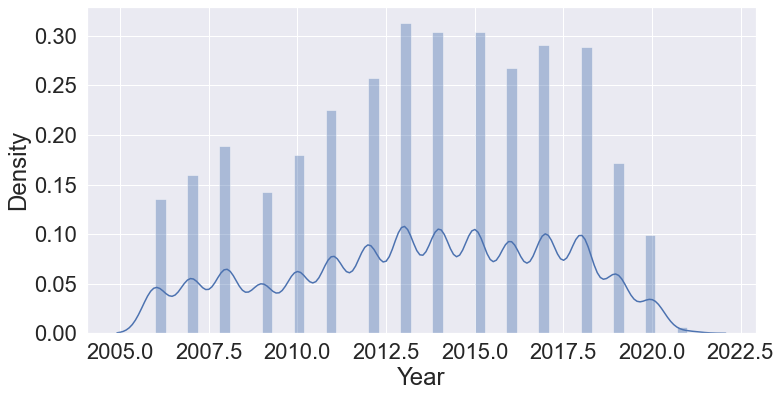

In [83]:
# Distribution of the dataset over the Year of the Vehicles
sns.distplot((vehicles_df["Year"]))

<AxesSubplot:xlabel='Mileage', ylabel='Density'>

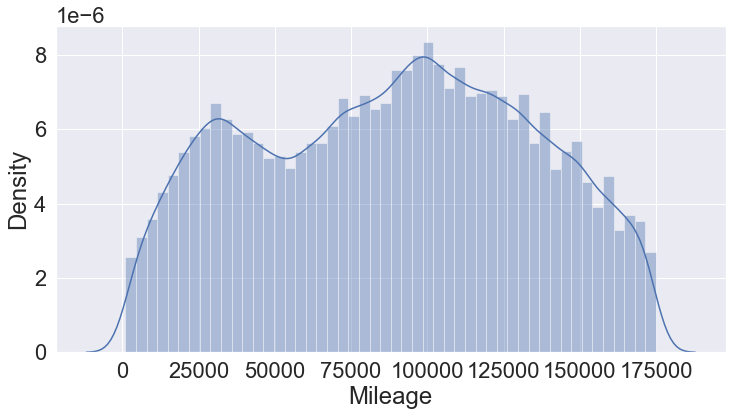

In [84]:
# Distribution of the dataset over the Milage of the Vehicles
sns.distplot((vehicles_df["Mileage"]))

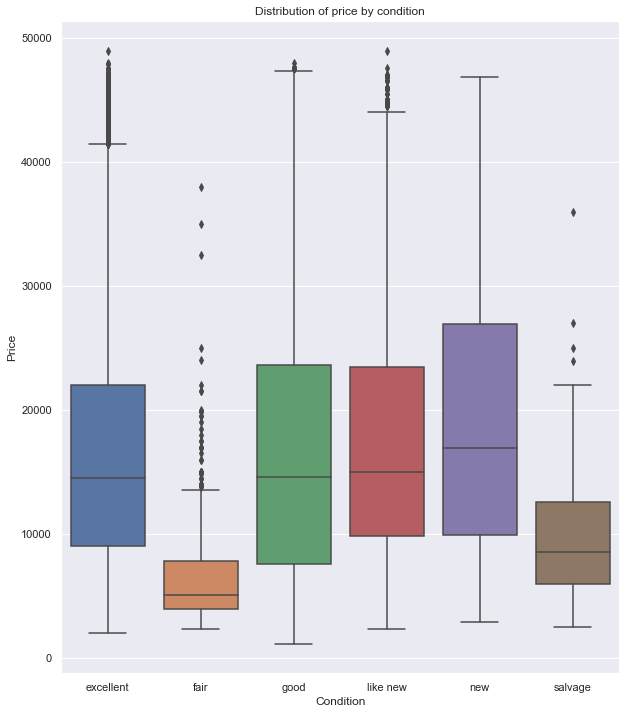

In [85]:
### Verify relationship between price and condition category

sns.set(rc={'figure.figsize':(10,12)})
sns.boxplot(data=vehicles_df, x='Condition', y='Price').set(title='Distribution of price by condition')
plt.show()

Vehicles with new, like new and good condition have higher price than those fair and salvage.

The log transformation is, arguably, the most popular among the different types of transformations used to transform skewed data to approximately conform to normality. If the original data follows a log-normal distribution or approximately so, then the log-transformed data follows a normal or near normal distribution.

Log normalization is the process of converting each log data field or entry to a standardized data representation and categorizing it consistently. In log normalization, the given log data is converted into consistent representations and categorizations.


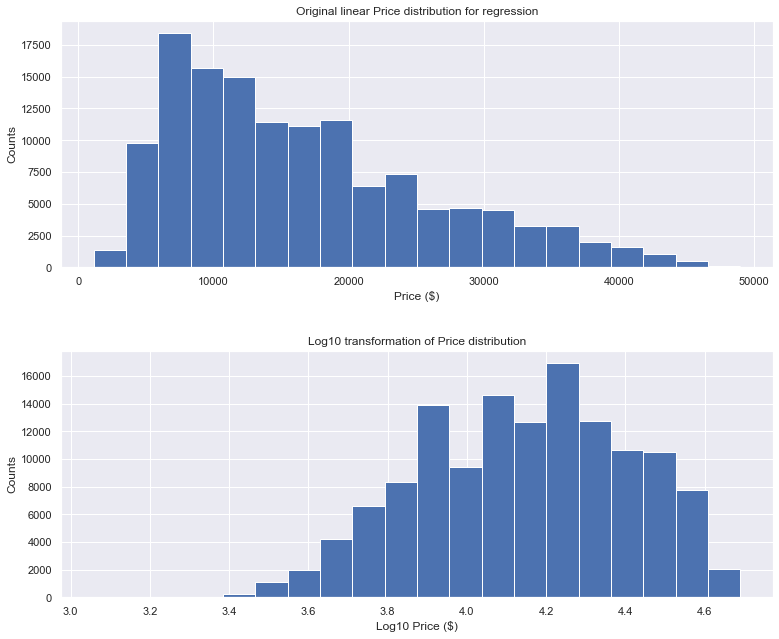

In [86]:
# compare original distribution of y-target price values 

fig, axs = plt.subplots(2, 1, figsize=(12,10))
fig.tight_layout(pad=5.0)

axs[0].hist(vehicles_df['Price'], bins=20)
axs[0].set_xlabel('Price ($)')
axs[0].set_ylabel('Counts')
axs[0].set_title('Original linear Price distribution for regression')

axs[1].hist( np.log10(vehicles_df['Price']), bins=20)
axs[1].set_xlabel('Log10 Price ($)')
axs[1].set_ylabel('Counts')
axs[1].set_title('Log10 transformation of Price distribution')
plt.show()

In [87]:
#applying log transformation to 'Price' Column
vehicles_df['Price'] = np.log(vehicles_df['Price'])

###### Final check for duplicates.

In [88]:
vehicles_df.duplicated().sum()

1658

In [89]:
## Remove duplicats.
vehicles_df.drop_duplicates(inplace=True)

vehicles_df.shape

(132137, 13)

In [90]:
#Final cleaned data
vehicles_final = vehicles_df.copy(deep=True)

vehicles_final.shape

(132137, 13)

#### Examining the Correlations

What feature has the highest positive correlation with Sale price? 

In [91]:
highest_corr = vehicles_final.corr()[['Price']].nlargest(columns = 'Price', n = 2).index[1]
print(highest_corr)

Year


In [92]:
# Find most important features relative to target Price
print("Find most important features relative to target")
corr = vehicles_final.corr()
corr.sort_values(["Price"], ascending = False, inplace = True)
print(corr.Price)

Find most important features relative to target
Price      1.000000
Year       0.739751
Mileage   -0.611365
Name: Price, dtype: float64


Between Year and Price there is a positive correlation, meaning that the higher
is the Year (more recent), the higher is the Price (more recent cars cost more).
Between Price and Mileage there is a negative correlation, meaning that higher
is the mileage, lower is the Price (cars with high mileage cost less).

In [93]:
percentage_data_loss = (1- round(vehicles_final.shape[0]/vehicles_initial_dataset,3))*100
print("Percentage of data loss after final data processing is {}%.".format(percentage_data_loss))

Percentage of data loss after final data processing is 69.0%.


###### Our dataframe ready for training/test 

In [94]:
X = vehicles_final.drop('Price', axis = 1)
y = vehicles_final['Price']

In [95]:
#test/train split 30/70 and random_state = 42

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape)
print(X_test.shape)

(92495, 12)
(39642, 12)


## Modeling

With the final dataset in hand, it is now time to build some models.  Here, we build a number of different regression models with the price as the target.  In building the models, we explored different parameters and cross-validate the findings.

Because we are using regularization, it is important to have each of the features represented on the same scale. 
To do so, use the StandardScaler for Year and Mileage

using column Transformer and OneHotEncoder and ordinalecoder to transform the categorical featues into numerical for Modeling

In [96]:
#### create column transformer for pipeline 

column_transformer = make_column_transformer(
    (StandardScaler(), ['Year', 'Mileage']),
    (OneHotEncoder(handle_unknown='ignore'), ['Cylinders', 'Paint_Color','Fuel','Manufacturer', 'Title_Status', 'Transmission', 'Drive', 'Size', 'Type'] ),
    (OrdinalEncoder(categories=[['salvage', 'fair', 'good', 'excellent', 'like new', 'new','other']]), ['Condition']),
    remainder='passthrough', verbose_feature_names_out=False )       


#####  Start with standard Linear regression.

In [97]:
#### standard linar regression
column_transformer.fit_transform(X_train)
linear_reg_model = make_pipeline(column_transformer, LinearRegression())
linear_reg_model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['Year', 'Mileage']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Cylinders', 'Paint_Color',
                                                   'Fuel', 'Manufacturer',
                                                   'Title_Status',
                                                   'Transmission', 'Drive',
                                                   'Size', 'Type']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(categories=[['salvage',
                                                                              'fair',
                                                                              'good',
                                                                              'excellent',
                                                                              'like '
                                                                              'new',
                                                                              'new',
                                                                              'other']]),
                                                  ['Condition'])],
                                   verbose_feature_names_out=False)),
                ('linearregression', LinearRegression())])

In [98]:
linear_reg_mae_train = mean_absolute_error(linear_reg_model.predict(X_train), y_train)
linear_reg_mae_test = mean_absolute_error(linear_reg_model.predict(X_test), y_test)
linear_reg_score = linear_reg_model.score(X_test, y_test)

best_mae_linear=(f'Linear Regression MAE train={linear_reg_mae_train: .4f}, Test={linear_reg_mae_test: .4f}')
print(f'Linear Regression MAE train:\t{linear_reg_mae_train}')
print(f'Linear Regression MAE test:\t{linear_reg_mae_test}')
print(f'Linear Regression Score:\t{linear_reg_score}')

Linear Regression MAE train:	0.21571313134483713
Linear Regression MAE test:	0.21728914288531834
Linear Regression Score:	0.7818759980169201


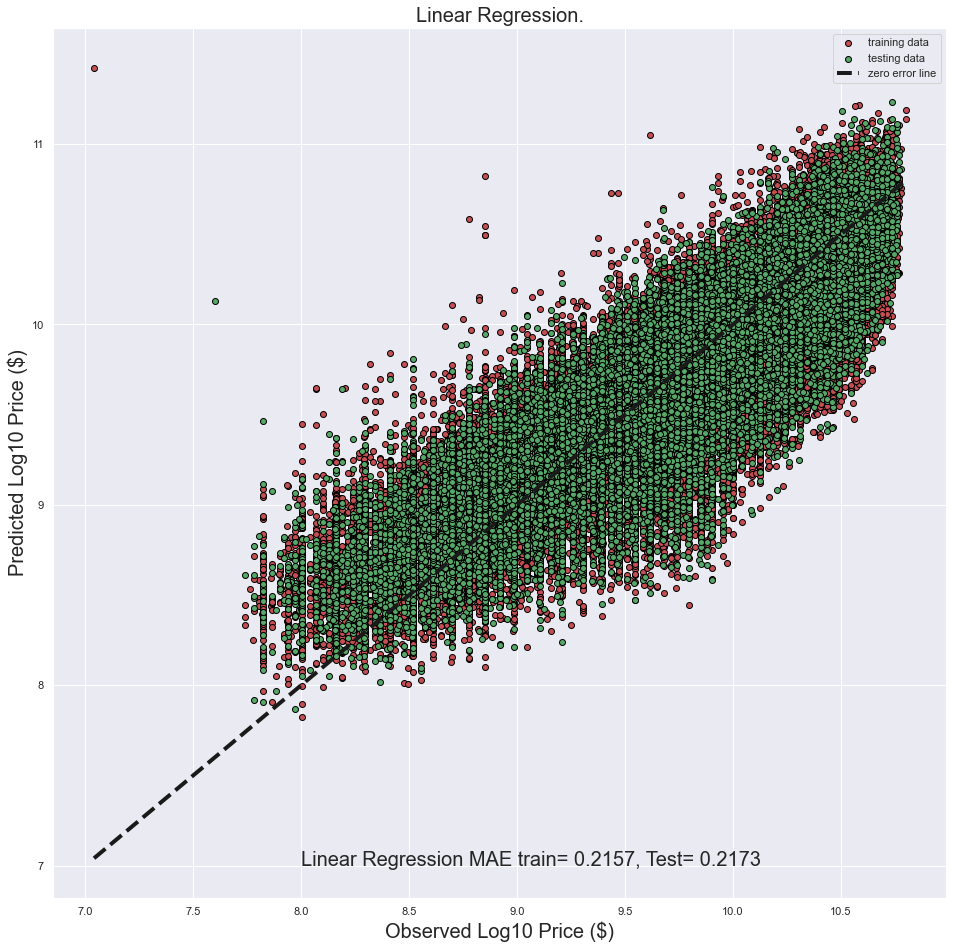

In [99]:
fig, axes = plt.subplots(1, 1, figsize=(16,16))

axes.scatter(y_train, linear_reg_model.predict(X_train),c='r',edgecolors=(0,0,0),label='training data')
axes.scatter(y_test, linear_reg_model.predict(X_test), c='g',edgecolors=(0,0,0), label='testing data')
axes.plot([y.min(), y.max()], [y.min(), y.max()], "k--", lw=4, label='zero error line')
axes.set_xlabel("Observed Log10 Price ($)",fontsize=20)
axes.set_ylabel("Predicted Log10 Price ($)",fontsize=20)
axes.set_title("Linear Regression.",fontsize=20 )
axes.text(8, 7.00, best_mae_linear, fontsize=20)
axes.legend()

Cross validation of Linear Regression

In [100]:
%time cv_scores_lr = cross_val_score(linear_reg_model, X, y, cv = 5 )

CPU times: total: 20.4 s
Wall time: 6.36 s


In [101]:
print('Cross validation scores (5 folds): {}'.format(cv_scores_lr))
print('The average cross validation score (5 folds): {}'.format(np.mean(cv_scores_lr)))

Cross validation scores (5 folds): [0.41932702 0.57611572 0.60562115 0.54530228 0.42907907]
The average cross validation score (5 folds): 0.5150890486812484


##### Compare RIDGE and LASSO regression models

In [102]:
### Setup Ridge regression pipeline workflow and grid search for hyperparameter alpha-regularization
###
ridge_param_dict = {'ridge__alpha': np.logspace(-5, 5, 50)}
pipe_ridge = Pipeline([
    ('transformer', column_transformer),
    ('ridge', Ridge())
])
grid_ridge = GridSearchCV( pipe_ridge, param_grid = ridge_param_dict )

In [103]:
%time grid_ridge.fit( X_train, y_train )

CPU times: total: 6min 46s
Wall time: 2min 24s


GridSearchCV(estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['Year',
                                                                          'Mileage']),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Cylinders',
                                                                          'Paint_Color',
                                                                          'Fuel',
                                                                          'Manufacturer',
                                                                          'Title_Status',
                                                                          'Transmission',
                                                                          'Drive',
                                                                          'Size',
                                                                          'Type']),
                                                                        ('ordinalencoder',
                                                                         OrdinalE...
       7.90604321e-01, 1.26485522e+00, 2.02358965e+00, 3.23745754e+00,
       5.17947468e+00, 8.28642773e+00, 1.32571137e+01, 2.12095089e+01,
       3.39322177e+01, 5.42867544e+01, 8.68511374e+01, 1.38949549e+02,
       2.22299648e+02, 3.55648031e+02, 5.68986603e+02, 9.10298178e+02,
       1.45634848e+03, 2.32995181e+03, 3.72759372e+03, 5.96362332e+03,
       9.54095476e+03, 1.52641797e+04, 2.44205309e+04, 3.90693994e+04,
       6.25055193e+04, 1.00000000e+05])})

In [104]:
## get the best model from grid search
##
best_model_ridge = grid_ridge.best_estimator_
best_alpha_ridge  = grid_ridge.best_params_
best_alpha_str=(f'Optimal alpha: {list(best_alpha_ridge.values())[0].round(3)}')
train_mse = mean_squared_error(y_train, best_model_ridge.predict(X_train))
test_mse = mean_squared_error(y_test, best_model_ridge.predict(X_test))
best_mse_str=(f'MSE: Training={train_mse: .4f}, Test={test_mse: .4f}')
train_mae = median_absolute_error( y_train, best_model_ridge.predict(X_train) )
test_mae = median_absolute_error( y_train, best_model_ridge.predict(X_train) )
best_mae_str=(f'MAE: Training={train_mae: .4f}, Test={test_mae: .4f}')
print(best_mae_str)
print(best_mse_str)
print(best_alpha_str)

MAE: Training= 0.1716, Test= 0.1716
MSE: Training= 0.0789, Test= 0.0794
Optimal alpha: 0.007


In [105]:
#### Setup LASSO regression pipeline workflow and grid search for hyperparameter alpha-regularization

lasso_param_dict = { 'lasso__alpha' : np.logspace(-5, 5, 50)}
pipe_lasso = Pipeline([
    ('transformer', column_transformer),
    ('lasso', Lasso())
])
grid_lasso = GridSearchCV( pipe_lasso, param_grid = lasso_param_dict )


In [106]:
%time grid_lasso.fit( X_train, y_train )

CPU times: total: 14min 31s
Wall time: 9min 49s


GridSearchCV(estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['Year',
                                                                          'Mileage']),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Cylinders',
                                                                          'Paint_Color',
                                                                          'Fuel',
                                                                          'Manufacturer',
                                                                          'Title_Status',
                                                                          'Transmission',
                                                                          'Drive',
                                                                          'Size',
                                                                          'Type']),
                                                                        ('ordinalencoder',
                                                                         OrdinalE...
       7.90604321e-01, 1.26485522e+00, 2.02358965e+00, 3.23745754e+00,
       5.17947468e+00, 8.28642773e+00, 1.32571137e+01, 2.12095089e+01,
       3.39322177e+01, 5.42867544e+01, 8.68511374e+01, 1.38949549e+02,
       2.22299648e+02, 3.55648031e+02, 5.68986603e+02, 9.10298178e+02,
       1.45634848e+03, 2.32995181e+03, 3.72759372e+03, 5.96362332e+03,
       9.54095476e+03, 1.52641797e+04, 2.44205309e+04, 3.90693994e+04,
       6.25055193e+04, 1.00000000e+05])})

In [107]:
## get the best model from grid search
##
best_model_lasso = grid_lasso.best_estimator_
best_alpha_lasso = grid_lasso.best_params_
best_alpha_str2=(f'Optimal alpha: {list(best_alpha_lasso.values())[0].round(5)}')

train_mse = mean_squared_error(y_train, best_model_lasso.predict(X_train))
test_mse = mean_squared_error(y_test, best_model_lasso.predict(X_test))
best_mse_str2=(f'MSE: Training={train_mse: .4f}, Test={test_mse: .4f}')

train_mae = median_absolute_error( y_train, best_model_lasso.predict(X_train) )
test_mae = median_absolute_error( y_train, best_model_lasso.predict(X_train) )
best_mae_str2=(f'MAE: Training={train_mae: .4f}, Test={test_mae: .4f}')

print(best_mae_str2)
print(best_mse_str2)
print(best_alpha_str2)

MAE: Training= 0.1716, Test= 0.1716
MSE: Training= 0.0789, Test= 0.0794
Optimal alpha: 1e-05


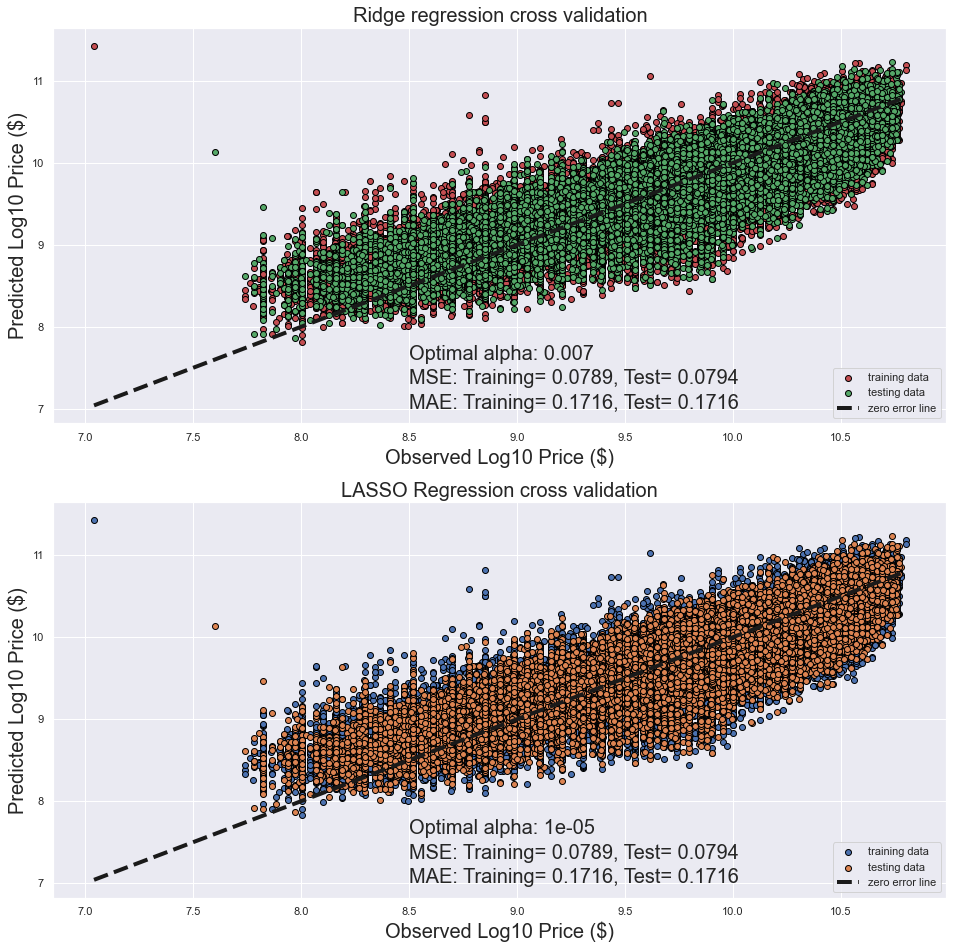

In [108]:
# compare observed and predicted price from two regression models

#from sklearn.metrics import PredictionErrorDisplay

fig, axes = plt.subplots(2, 1, figsize=(16,16))

axes[0].scatter(y_train, best_model_ridge.predict(X_train),c='r',edgecolors=(0, 0,0),label='training data')
axes[0].scatter(y_test, best_model_ridge.predict(X_test), c='g',edgecolors=(0, 0,0), label='testing data')
#axes[0].scatter(y_test, best_model_grid.predict(X_test), edgecolors=(0, 0, 0), label='testing data')
axes[0].plot([y.min(), y.max()], [y.min(), y.max()], "k--", lw=4, label='zero error line')
axes[0].set_xlabel("Observed Log10 Price ($)",fontsize=20)
axes[0].set_ylabel("Predicted Log10 Price ($)",fontsize=20)
axes[0].set_title("Ridge regression cross validation",fontsize=20)
axes[0].text(8.5, 7.6, best_alpha_str,fontsize=20)
axes[0].text(8.5, 7.3, best_mse_str,fontsize=20)
axes[0].text(8.5, 7, best_mae_str,fontsize=20)
axes[0].legend()

axes[1].scatter(y_train, best_model_lasso.predict(X_train),edgecolors=(0, 0,0),label='training data')
axes[1].scatter(y_test, best_model_lasso.predict(X_test),edgecolors=(0, 0,0),label='testing data')
axes[1].plot([y.min(), y.max()], [y.min(), y.max()], "k--", lw=4, label='zero error line')
axes[1].set_xlabel("Observed Log10 Price ($)",fontsize=20)
axes[1].set_ylabel("Predicted Log10 Price ($)",fontsize=20)
axes[1].set_title("LASSO Regression cross validation",fontsize=20)
axes[1].text(8.5, 7.6, best_alpha_str2,fontsize=20)
axes[1].text(8.5, 7.3, best_mse_str2,fontsize=20)
axes[1].text(8.5, 7, best_mae_str2,fontsize=20)
axes[1].legend()
plt.show()

Distribution of samples on train and test is not uniform so we used K-fold cross-validation
on our model to test the ability of our model to predict new data. It is also used to flag problems like overfitting or selection bias.

In this case we use five fold cross validation.

In [109]:
### Cross Validation Ridge 
%time cv_scores_ridge = cross_val_score(grid_ridge, X, y, cv = 5 )

CPU times: total: 34min 13s
Wall time: 11min 46s


In [112]:
print('Cross validation scores (5 folds): {}'.format(cv_scores_ridge))
print('The average cross validation score (5 folds): {}'.format(np.mean(cv_scores_ridge)))

Cross validation scores (5 folds): [0.42158758 0.57581499 0.60514729 0.54505297 0.42608012]
The average cross validation score (5 folds): 0.514736591354956


In [113]:
### Cross Validation LASSO
%time cv_scores_lasso = cross_val_score( grid_lasso, X, y, cv = 5 )

CPU times: total: 1h 32min 1s
Wall time: 54min 15s


In [114]:
print('Cross validation scores (5 folds): {}'.format(cv_scores_lasso))
print('The average cross validation score (5 folds): {}'.format(np.mean(cv_scores_lasso)))

Cross validation scores (5 folds): [0.42179302 0.57554847 0.60486552 0.54476642 0.41992269]
The average cross validation score (5 folds): 0.5133792244699332


## Evaluation
With some modeling accomplished, next step is filter out the dominant features and coefficient.

In [117]:
### get coef from regression and column transformer and create a dataframe

feature_columns = best_model_ridge.named_steps["transformer"].get_feature_names_out()

coefs_ridge = pd.DataFrame(best_model_ridge.named_steps["ridge"].coef_,
                    columns=['coefficients'], 
                    index=feature_columns )

coefs_ridge_sorted = coefs_ridge.sort_values('coefficients', ascending=False)
coefs_ridge_sorted['coefficients'] = coefs_ridge_sorted.coefficients.round(5)
coefs_ridge_sorted

,coefficients
Manufacturer_tesla,0.56811
Manufacturer_porsche,0.46890
Year,0.35233
Manufacturer_lexus,0.33881
Manufacturer_rover,0.22881
...,...
Manufacturer_mitsubishi,-0.27207
Cylinders_3 cylinders,-0.27356
Manufacturer_harley-davidson,-0.28125
Manufacturer_mercury,-0.34902


In [129]:
# import sklearn
# print(sklearn.__version__)

In [130]:
#!pip install scikit-learn

In [131]:
# !conda update conda 
# !pip install -U scikit-learn

In [118]:
### get coef from regression and column transformer and create a dataframe

feature_columns = best_model_lasso.named_steps["transformer"].get_feature_names_out()

coefs_lasso = pd.DataFrame( best_model_lasso.named_steps["lasso"].coef_,
                    columns=['coefficients'], 
                    index=feature_columns )

coefs_lasso_sorted = coefs_lasso.sort_values('coefficients', ascending=False)
coefs_lasso_sorted['coefficients'] = coefs_lasso_sorted.coefficients.round(5)
coefs_lasso_sorted

,coefficients
Manufacturer_tesla,0.53604
Manufacturer_porsche,0.46339
Year,0.35243
Manufacturer_lexus,0.33630
Fuel_diesel,0.26298
...,...
Manufacturer_harley-davidson,-0.24004
Manufacturer_mitsubishi,-0.27369
Cylinders_3 cylinders,-0.28105
Manufacturer_mercury,-0.34149


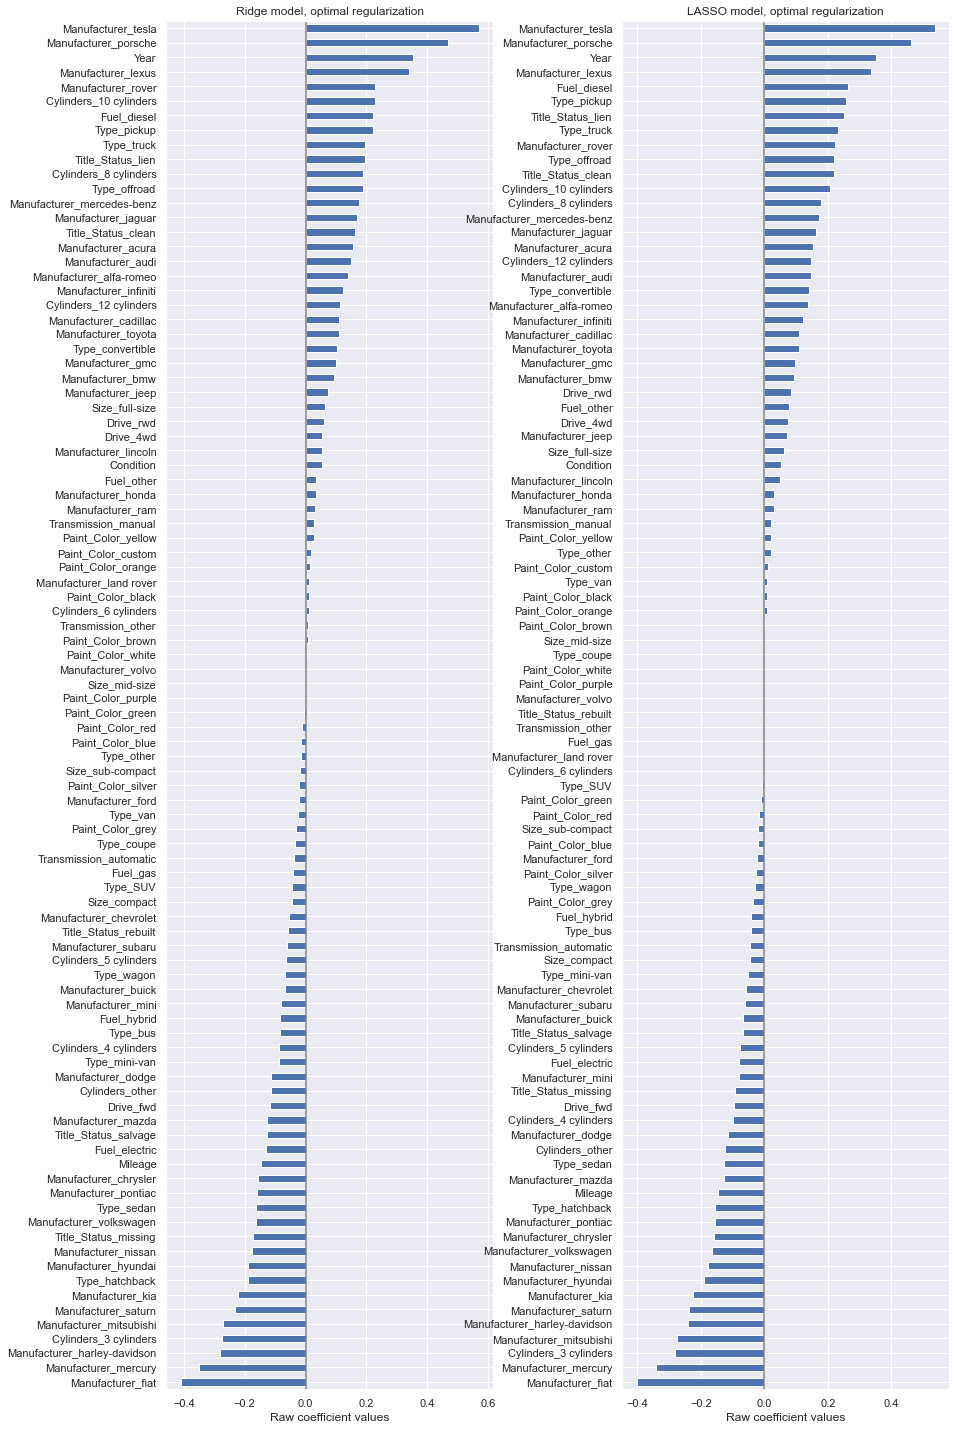

In [128]:
### plot coef from regression and column transformer 

coefs_ridge_sorted= coefs_ridge_sorted.sort_values('coefficients', ascending=True)
coefs_lasso_sorted = coefs_lasso_sorted.sort_values('coefficients', ascending=True)

fig, axes = plt.subplots(1,2,figsize=(14,22))
fig.tight_layout(pad=8)

coefs_ridge_sorted.plot.barh(ax=axes[0], legend=False )
axes[0].set_title("Ridge model, optimal regularization")
axes[0].axvline(x=0, color=".5")
axes[0].set_xlabel("Raw coefficient values")

coefs_lasso_sorted.plot.barh(ax=axes[1], legend=False )
axes[1].set_title("LASSO model, optimal regularization")
axes[1].axvline(x=0, color=".5")
ax = axes[1].set_xlabel("Raw coefficient values")

Both regression models resulted in similar ordering of coefficients and resulting weights.From the categorical coefficients we observe that manufatures type does singnificantly influence decision making in the used car buying and selling bussiness. Both models show that Tesla and Porsche have high positive weight and Mercury and Fiat have strong negative weight on both models. Among the numerical features  the year has a high positive weight with log10-price and Mileage has a strong negative weight as shown in the correlation analysis. 
We also noticed that vehicles with 10 and 8 Cylinder size, diesel, pickup and truck have a higher ranking but cars with Cyliinder size 3 are ranked low along with Harley Davidson vehicles/bikes.From the categorical coefficients we see that trucks, offroad, pickup vehicles are weighted higher. Electric vehicles in general are ranked low.

## Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.

perform a direct application of regression model for two cars data taken from kbb.com
#data reference: kbb estimates from my two cars.

In [119]:
vehicles_categorical_features = vehicles_final.select_dtypes(exclude=np.number).columns.tolist()
vehicles_categorical_features 

['Manufacturer',
 'Condition',
 'Cylinders',
 'Fuel',
 'Title_Status',
 'Transmission',
 'Drive',
 'Size',
 'Type',
 'Paint_Color']

In [120]:
vehicles_final.columns

Index(['Manufacturer', 'Condition', 'Cylinders', 'Fuel', 'Title_Status',
       'Transmission', 'Drive', 'Size', 'Type', 'Paint_Color', 'Price', 'Year',
       'Mileage'],
      dtype='object')

Create a data frame for testing

In [121]:
# A 2007 Toyota camry sedan with 166,000 miles on it.
df1 = pd.DataFrame( data={
                         'Manufacturer': 'toyota', 
                         'Condition': 'excellent',
                         'Cylinders': '4 cylinders',
                         'Fuel' : 'gas',
                         'Title_Status' : 'clean', 
                         'Transmission' :'automatic',
                         'Drive' : 'fwd',
                         'Size' : 'mid-size',
                         'Type' : 'sedan', 
                         'Paint_Color':'blue',
                         'Year': 2007,
                         'Mileage': 166000,
                         'kbb_low': 2429,
                         'kbb_hi': 3442, 
                         'predict_price': '0', 'regression': 'ridge' }, index=[1] )

# A 2019 Kia Niro hybrid fit subcompact hatchback with 33k mi

df2 = pd.DataFrame( data={
                         'Manufacturer': 'kia', 
                         'Condition': 'excellent',
                         'Cylinders': '4 cylinders',
                         'Fuel' : 'hybrid',
                         'Title_Status' : 'clean', 
                         'Transmission' :'automatic',
                         'Drive' : 'fwd',
                         'Size' : 'sub-compact',
                         'Type' : 'mini-van', 
                         'Paint_Color':'grey',
                         'Year': 2019,
                         'Mileage': 33000,
                         'kbb_low': 20895,
                         'kbb_hi': 22441, 
                         'predict_price': '0', 'regression': 'ridge' }, index=[1] )

df3 = pd.DataFrame( data={
                         'Manufacturer': 'toyota', 
                         'Condition': 'excellent',
                         'Cylinders': '4 cylinders',
                         'Fuel' : 'gas',
                         'Title_Status' : 'clean', 
                         'Transmission' :'automatic',
                         'Drive' : 'fwd',
                         'Size' : 'mid-size',
                         'Type' : 'sedan', 
                         'Paint_Color':'blue',
                         'Year': 2007,
                         'Mileage': 166000,
                         'kbb_low': 2429,
                         'kbb_hi': 3442, 
                         'predict_price': '0', 'regression': 'lasso' }, index=[1] )


df4 = pd.DataFrame( data={
                         'Manufacturer': 'kia', 
                         'Condition': 'excellent',
                         'Cylinders': '4 cylinders',
                         'Fuel' : 'hybrid',
                         'Title_Status' : 'clean', 
                         'Transmission' :'automatic',
                         'Drive' : 'fwd',
                         'Size' : 'sub-compact',
                         'Type' : 'mini-van', 
                         'Paint_Color':'grey',
                         'Year': 2019,
                         'Mileage': 33000,
                         'kbb_low': 20895,
                         'kbb_hi': 22441, 
                         'predict_price': '0', 'regression': 'lasso' }, index=[1] )

df5 = pd.DataFrame( data={
                         'Manufacturer': 'toyota', 
                         'Condition': 'excellent',
                         'Cylinders': '4 cylinders',
                         'Fuel' : 'gas',
                         'Title_Status' : 'clean', 
                         'Transmission' :'automatic',
                         'Drive' : 'fwd',
                         'Size' : 'mid-size',
                         'Type' : 'sedan', 
                         'Paint_Color':'blue',
                         'Year': 2007,
                         'Mileage': 166000,
                         'kbb_low': 2429,
                         'kbb_hi': 3442, 
                         'predict_price': '0', 'regression': 'lreg' }, index=[1] )


df6 = pd.DataFrame( data={
                         'Manufacturer': 'kia', 
                         'Condition': 'excellent',
                         'Cylinders': '4 cylinders',
                         'Fuel' : 'hybrid',
                         'Title_Status' : 'clean', 
                         'Transmission' :'automatic',
                         'Drive' : 'fwd',
                         'Size' : 'sub-compact',
                         'Type' : 'mini-van', 
                         'Paint_Color':'grey',
                         'Year': 2019,
                         'Mileage': 33000,
                         'kbb_low': 20895,
                         'kbb_hi': 22441, 
                         'predict_price': '0', 'regression': 'lreg' }, index=[1] )



df = pd.concat([df1,df2,df3,df4,df5,df6], ignore_index=True)
df['predict_price'] = df.predict_price.astype(float)
df

,Manufacturer,Condition,Cylinders,Fuel,Title_Status,Transmission,Drive,Size,Type,Paint_Color,Year,Mileage,kbb_low,kbb_hi,predict_price,regression
0,toyota,excellent,4 cylinders,gas,clean,automatic,fwd,mid-size,sedan,blue,2007,166000,2429,3442,0.0,ridge
1,kia,excellent,4 cylinders,hybrid,clean,automatic,fwd,sub-compact,mini-van,grey,2019,33000,20895,22441,0.0,ridge
2,toyota,excellent,4 cylinders,gas,clean,automatic,fwd,mid-size,sedan,blue,2007,166000,2429,3442,0.0,lasso
3,kia,excellent,4 cylinders,hybrid,clean,automatic,fwd,sub-compact,mini-van,grey,2019,33000,20895,22441,0.0,lasso
4,toyota,excellent,4 cylinders,gas,clean,automatic,fwd,mid-size,sedan,blue,2007,166000,2429,3442,0.0,lreg
5,kia,excellent,4 cylinders,hybrid,clean,automatic,fwd,sub-compact,mini-van,grey,2019,33000,20895,22441,0.0,lreg


In [123]:
### Comparisons with KBB: Ridge regression model


df.iloc[0,14] = (10**best_model_ridge.predict(df.iloc[[0]])).round(0)
df.iloc[1,14] = (10**best_model_ridge.predict(df.iloc[[1]])).round(0)


### Comparisons with KBB: LASSO regression model

df.iloc[2,14] = (10**best_model_lasso.predict(df.iloc[[2]])).round(0)
df.iloc[3,14] = (10**best_model_lasso.predict(df.iloc[[3]])).round(0)

### Comparisons with KBB: Linear regression model

df.iloc[4,14] = (10**linear_reg_model.predict(df.iloc[[4]])).round(0)
df.iloc[5,14] = (10**linear_reg_model.predict(df.iloc[[5]])).round(0)
df

,Manufacturer,Condition,Cylinders,Fuel,Title_Status,Transmission,Drive,Size,Type,Paint_Color,Year,Mileage,kbb_low,kbb_hi,predict_price,regression
0,toyota,excellent,4 cylinders,gas,clean,automatic,fwd,mid-size,sedan,blue,2007,166000,2429,3442,3.196498e+08,ridge
1,kia,excellent,4 cylinders,hybrid,clean,automatic,fwd,sub-compact,mini-van,grey,2019,33000,20895,22441,5.082106e+09,ridge
2,toyota,excellent,4 cylinders,gas,clean,automatic,fwd,mid-size,sedan,blue,2007,166000,2429,3442,3.194882e+08,lasso
3,kia,excellent,4 cylinders,hybrid,clean,automatic,fwd,sub-compact,mini-van,grey,2019,33000,20895,22441,5.093768e+09,lasso
4,toyota,excellent,4 cylinders,gas,clean,automatic,fwd,mid-size,sedan,blue,2007,166000,2429,3442,3.198079e+08,lreg
5,kia,excellent,4 cylinders,hybrid,clean,automatic,fwd,sub-compact,mini-van,grey,2019,33000,20895,22441,1.000000e+01,lreg


The above application of two example vehicles show that the model failed to work well in comparison with Kelly Blue Book (kbb.com) low and high value range.

## Observation/Future plan

After the data is cleaned up and processed these are some of the observations drawn.

1. We have about 51% accuracy of the three models tried (LinearRegression, Ridge and LASSO)

2. Both regression models (Ridge and LASSO) resulted in similar ordering of coefficients and resulting weights.From the categorical coefficients we observe that manufatures type does singnificantly influence decision making in the used car buying and selling bussiness.

3. Between Year and Price there is a positive correlation, meaning that the higher is the Year (more recent), the higher is the Price (more recent cars cost more). Between Price and Mileage there is a negative correlation, meaning that higher is the mileage, lower is the Price (cars with high mileage cost less).

4. We also noticed that vehicles with 10 and 8 Cylinder size, diesel, pickup and truck have a higher ranking but cars with Cyliinder size 3 are ranked low along with Harley Davidson vehicles/bikes.

5. From the categorical coefficients we see that trucks, offroad, pickup vehicles are weighted higher. Electric vehicles in general are ranked low.

6. The car features Manufacturer, year, cylinders, and Mileage were the most important one.

7. We identify some variability in several coefficients that indicate that they are not well resolved. These include 'other' categories (e.g., fuel_other, type_other, cylinder_other) that may not be well represented in the dataset. Also, less represented features like 3-cylinders, off-road, bus, fuel_electric may not be well represented in the dataset.

8. Both models show that Tesla and Porsche have high positive weight and Mercury and Fiat have strong negative weight. Among the numerical features  the year has a high positive weight with log10-price and Mileage has a strong negative weight as shown in the correlation analysis. 

9. We tried to demonstrate that for two vehicles I own (2019 Kia and 2007 Toyota Camr) but  the model predicts the value of the vehicle within the range of the Kelly Blue Book value (kbb.com). This demonstrates the usefulness of the model.


Recommend to fine-tune the dataset and model further to imporve the accuracy.